In [1]:
%load_ext autoreload
%autoreload 2


In [37]:
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb

import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
df_raw = pd.read_csv("term-deposit-marketing-2020.csv", low_memory=True)
df_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [31]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [32]:
df_raw.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,40000,NaN,NaN,NaN,40.5446,9.64178,19,33,39,48,95
job,40000,12,blue-collar,9383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,40000,3,married,24386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,40000,4,secondary,20993,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,40000,2,no,39191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,40000,NaN,NaN,NaN,1274.28,2903.77,-8019,54,407,1319,102127
housing,40000,2,yes,24031,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,40000,2,no,33070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,40000,3,cellular,24914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,40000,NaN,NaN,NaN,16.0172,8.27813,1,8,17,21,31


In [33]:
df_raw.tail(10).T

,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
age,26,33,45,32,35,53,30,54,34,38
job,technician,services,technician,management,management,technician,management,admin,management,technician
marital,single,single,married,married,married,married,single,divorced,married,married
education,secondary,tertiary,secondary,tertiary,tertiary,tertiary,tertiary,secondary,tertiary,secondary
default,no,no,no,no,no,no,no,no,no,no
balance,1231,1268,406,3154,3109,395,3340,200,1047,1442
housing,yes,yes,yes,no,yes,no,no,no,no,yes
loan,no,no,no,no,no,no,no,no,no,no
contact,cellular,cellular,cellular,cellular,cellular,cellular,cellular,cellular,cellular,cellular
day,3,3,3,3,3,3,3,3,3,3


Target Variable
no     37104
yes     2896
Name: y, dtype: int64


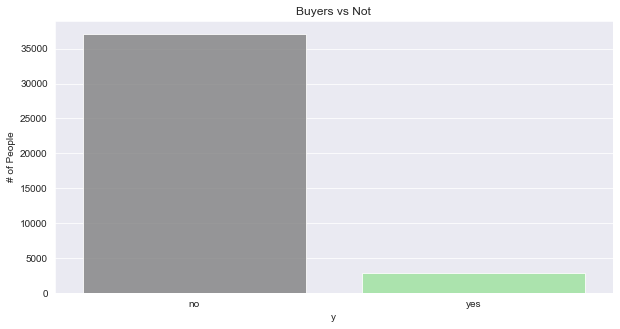

In [38]:
print('Target Variable')
print(df_raw["y"].value_counts())

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df_raw["y"], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Buyers vs Not')
plt.ylabel('# of People')
plt.show()

In [39]:
categorics = df_raw.select_dtypes(["object"]).columns
numerics = df_raw.select_dtypes(["int64"]).columns

print("Categorics: " + str(categorics))
print("\n")
print("Numerics: " + str(numerics))

Categorics: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'y'],
      dtype='object')


Numerics: Index(['age', 'balance', 'day', 'duration', 'campaign'], dtype='object')


In [40]:
print("Numerical Variables")
print(df_raw[numerics].describe())
print("\n")
print("--"*10)
print("Categorical Variables")
print("\n")
for i in categorics:
    print(i + ": ")
    print(df_raw[i].value_counts())
    print("\n")

Numerical Variables
                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000


--------------------
Categorical Variables


job: 
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student       

# Categorical Features

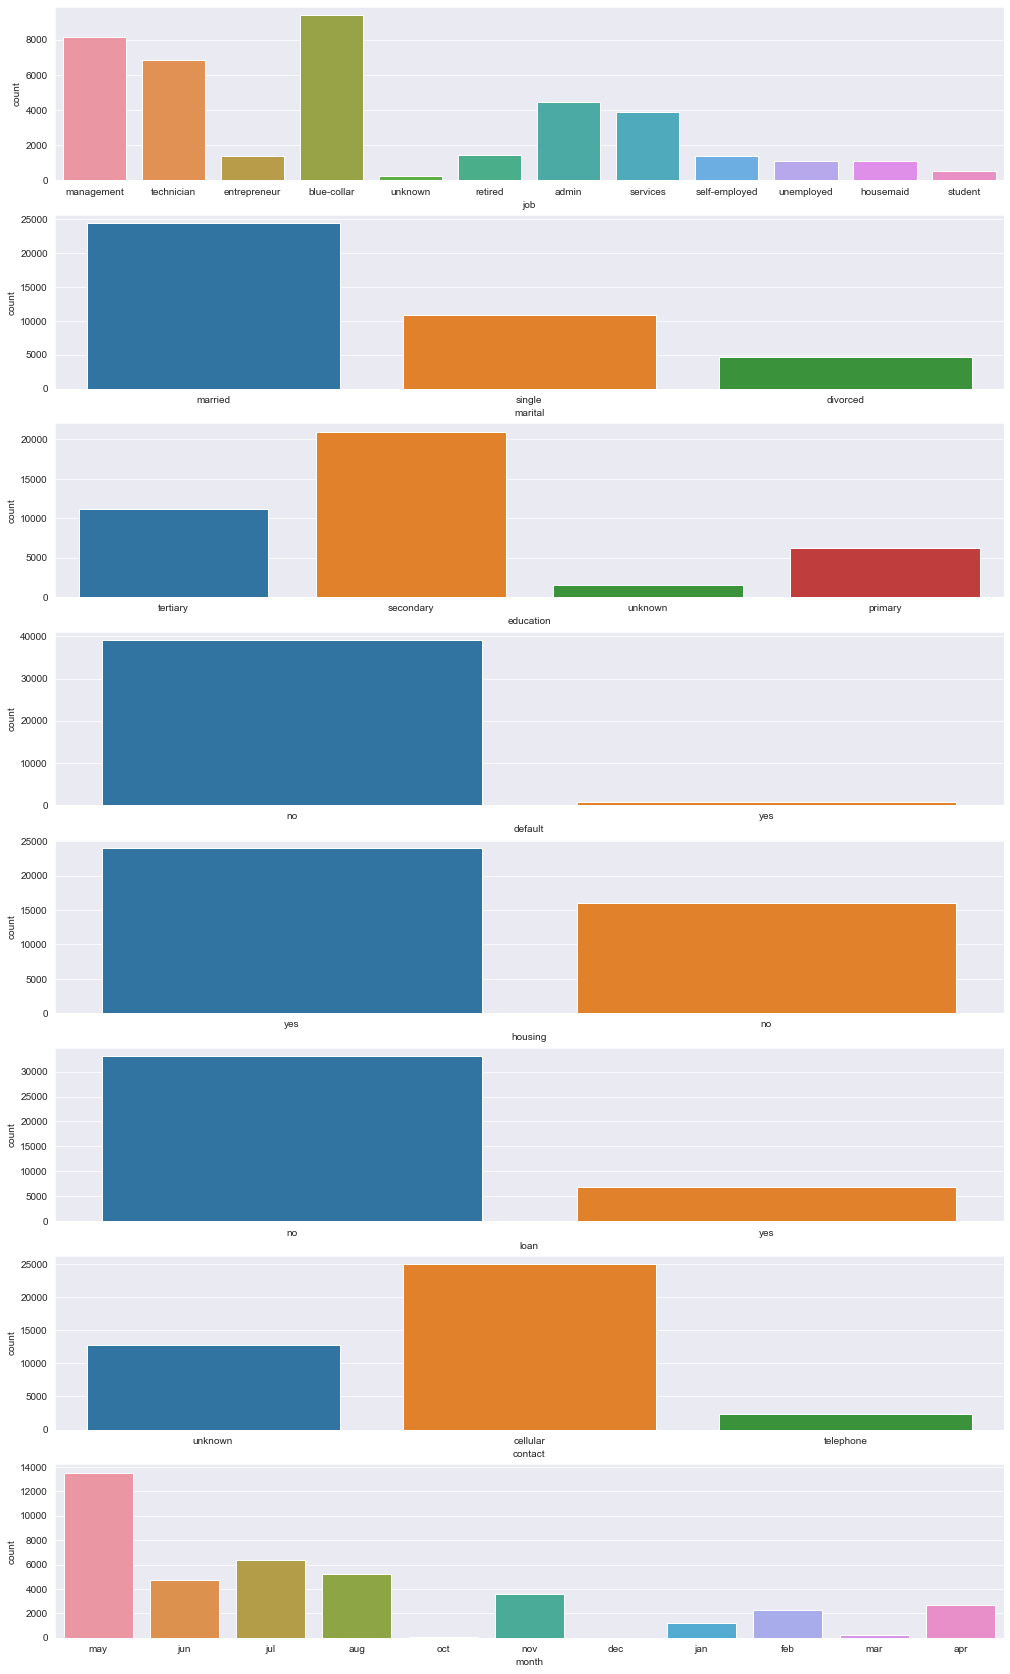

In [41]:
f, axes = plt.subplots(nrows=8,figsize=(17,30))
for j, i in enumerate(categorics[:-1]):
    sns.countplot(x=i,data=df_raw,ax=axes[j])

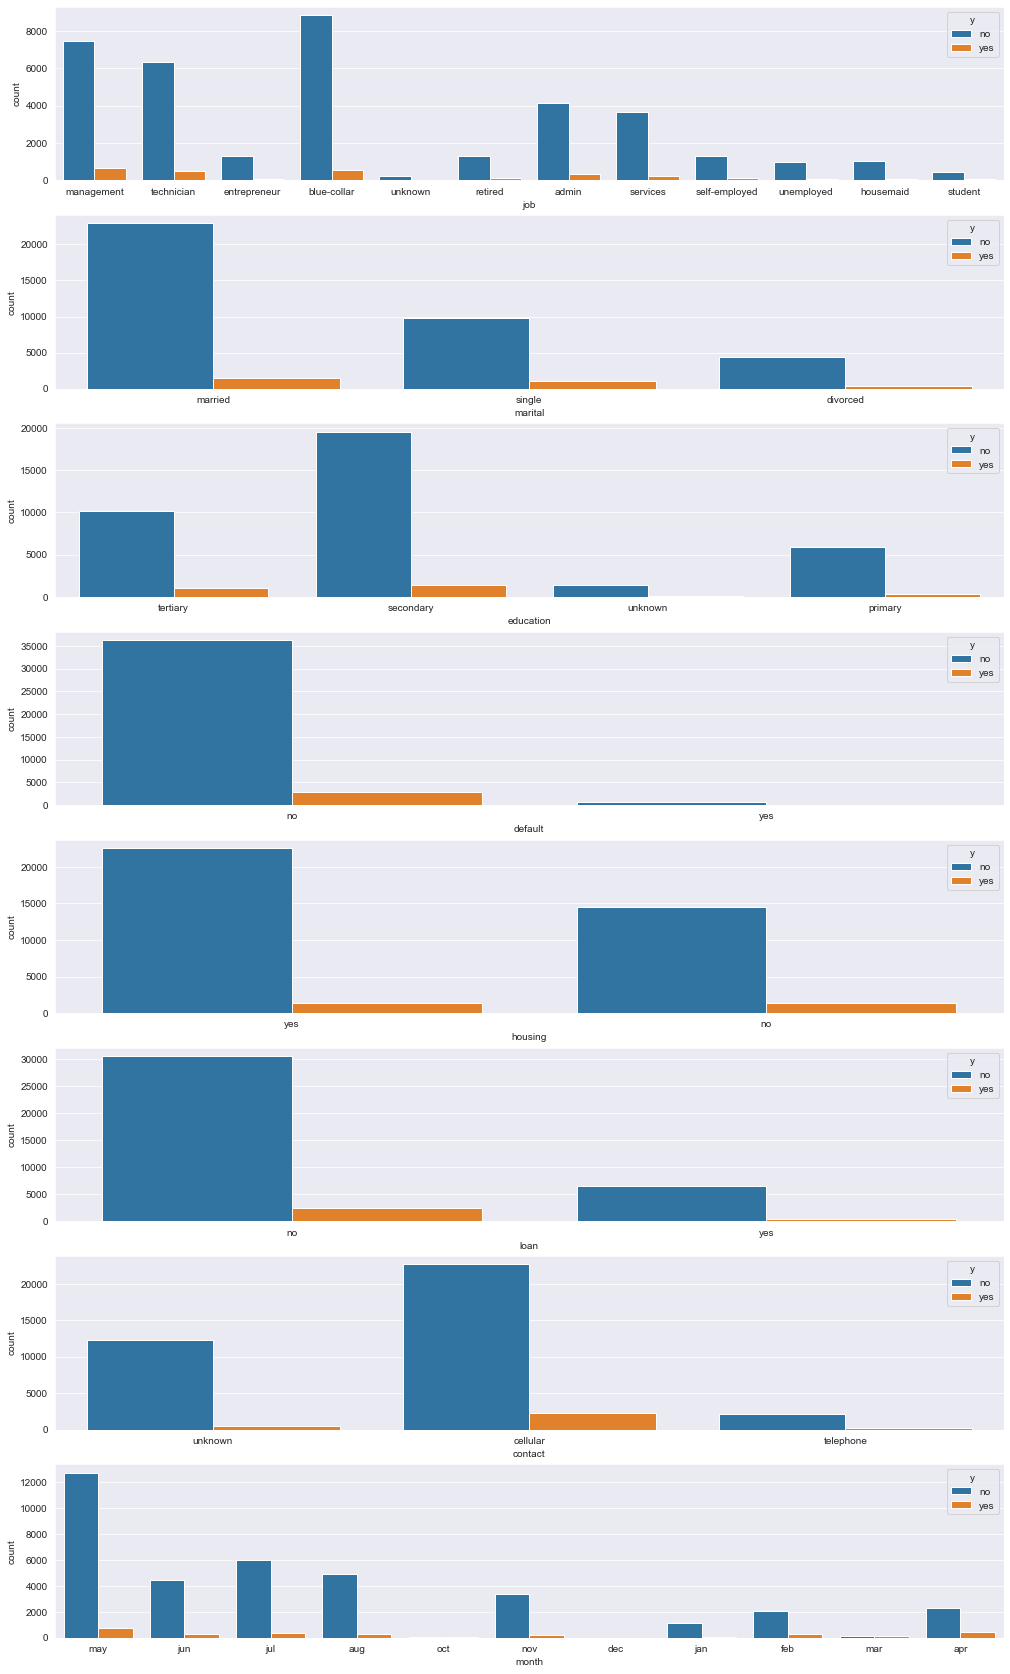

In [42]:
f, axes = plt.subplots(nrows=8, figsize=(17,30))
for j, i in enumerate(categorics[:-1]):
    sns.countplot(x=i,data=df_raw,ax=axes[j], hue="y")

In [43]:
for i in categorics[:-1]:
    display(pd.DataFrame(df_raw.groupby(i)["y"].value_counts()))

y
job           y        
admin         no   4132
              yes   351
blue-collar   no   8848
              yes   535
entrepreneur  no   1317
              yes    88
housemaid     no   1034
              yes    53
management    no   7490
              yes   676
retired       no   1286
              yes   151
self-employed no   1302
              yes   112
services      no   3672
              yes   238
student       no    442
              yes    82
technician    no   6355
              yes   497
unemployed    no   1008
              yes    96
unknown       no    218
              yes    17

y
marital  y         
divorced no    4334
         yes    391
married  no   22908
         yes   1478
single   no    9862
         yes   1027

y
education y         
primary   no    5917
          yes    353
secondary no   19575
          yes   1418
tertiary  no   10177
          yes   1029
unknown   no    1435
          yes     96

y
default y         
no      no   36344
        yes   2847
yes     no     760
        yes     49

y
housing y         
no      no   14537
        yes   1432
yes     no   22567
        yes   1464

y
loan y         
no   no   30554
     yes   2516
yes  no    6550
     yes    380

y
contact   y         
cellular  no   22681
          yes   2233
telephone no    2155
          yes    166
unknown   no   12268
          yes    497

y
month y         
apr   no    2267
      yes    451
aug   no    4927
      yes    288
dec   no      12
      yes      1
feb   no    2041
      yes    255
jan   no    1138
      yes     38
jul   no    5996
      yes    384
jun   no    4440
      yes    294
mar   no     133
      yes    125
may   no   12741
      yes    791
nov   no    3378
      yes    220
oct   yes     49
      no      31

In [44]:
for i in categorics[:-1]:
    display(pd.DataFrame(df_raw.groupby(i)["y"].value_counts()/df_raw.groupby(i).count()["y"]))

y
job           y            
admin         no   0.921704
              yes  0.078296
blue-collar   no   0.942982
              yes  0.057018
entrepreneur  no   0.937367
              yes  0.062633
housemaid     no   0.951242
              yes  0.048758
management    no   0.917218
              yes  0.082782
retired       no   0.894920
              yes  0.105080
self-employed no   0.920792
              yes  0.079208
services      no   0.939130
              yes  0.060870
student       no   0.843511
              yes  0.156489
technician    no   0.927466
              yes  0.072534
unemployed    no   0.913043
              yes  0.086957
unknown       no   0.927660
              yes  0.072340

y
marital  y            
divorced no   0.917249
         yes  0.082751
married  no   0.939391
         yes  0.060609
single   no   0.905685
         yes  0.094315

y
education y            
primary   no   0.943700
          yes  0.056300
secondary no   0.932454
          yes  0.067546
tertiary  no   0.908174
          yes  0.091826
unknown   no   0.937296
          yes  0.062704

y
default y            
no      no   0.927356
        yes  0.072644
yes     no   0.939431
        yes  0.060569

y
housing y            
no      no   0.910326
        yes  0.089674
yes     no   0.939079
        yes  0.060921

y
loan y            
no   no   0.923919
     yes  0.076081
yes  no   0.945166
     yes  0.054834

y
contact   y            
cellular  no   0.910372
          yes  0.089628
telephone no   0.928479
          yes  0.071521
unknown   no   0.961065
          yes  0.038935

y
month y            
apr   no   0.834069
      yes  0.165931
aug   no   0.944775
      yes  0.055225
dec   no   0.923077
      yes  0.076923
feb   no   0.888937
      yes  0.111063
jan   no   0.967687
      yes  0.032313
jul   no   0.939812
      yes  0.060188
jun   no   0.937896
      yes  0.062104
mar   no   0.515504
      yes  0.484496
may   no   0.941546
      yes  0.058454
nov   no   0.938855
      yes  0.061145
oct   yes  0.612500
      no   0.387500

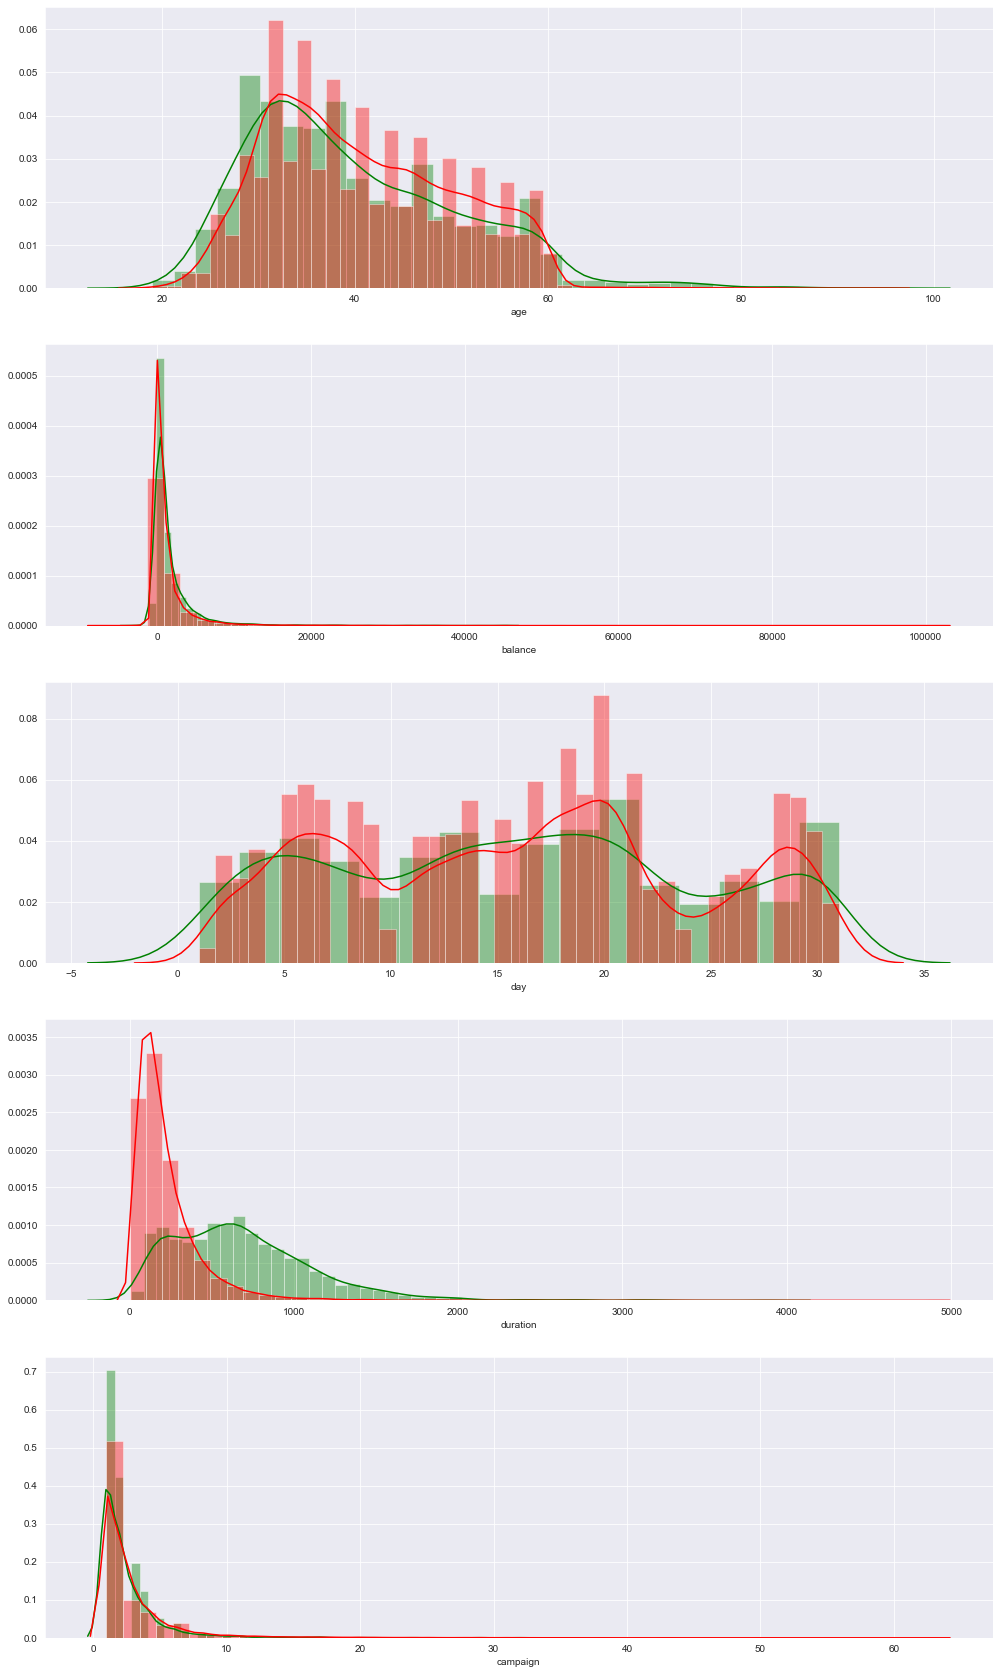

In [45]:
f, axes = plt.subplots(nrows=len(numerics),figsize=(17,30))
for j, i in enumerate(numerics):
    sns.distplot(a=df_raw[df_raw["y"]=="yes"][i] ,ax=axes[j], color="green")
    sns.distplot(a=df_raw[df_raw["y"]=="no"][i] ,ax=axes[j], color="red")

In [47]:
def train_cats(df):
    for n, c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype("category").cat.as_ordered()

In [48]:
def apply_cats(df, train):
    for n, c in df.items():
        if train[n].dtype == "category":
            df[n] = pd.Categorical(c, categories= train[n].cat.categories, ordered = True)

In [49]:
def print_score(m, X_train, X_valid, y_train, y_valid):
    reg_metrics = {
                        "Accuracy Score": [metrics.accuracy_score(y_train, m.predict(X_train)), metrics.accuracy_score(y_valid, m.predict(X_valid))],
                        "Recall Score": [metrics.recall_score(y_train, m.predict(X_train)), metrics.recall_score(y_valid, m.predict(X_valid))],
                        "Precision Score": [metrics.precision_score(y_train, m.predict(X_train)), metrics.precision_score(y_valid, m.predict(X_valid))],    
                        "F1 Score": [metrics.f1_score(y_train, m.predict(X_train)), metrics.f1_score(y_valid, m.predict(X_valid))],
                        "Roc Auc Score": [metrics.roc_auc_score(y_train, m.predict(X_train)), metrics.roc_auc_score(y_valid, m.predict(X_valid))]
                        
                  }
    
    df_reg_metrics = pd.DataFrame.from_dict(reg_metrics, orient='index', columns=["Train", "Validation"])
    return df_reg_metrics

In [50]:
def cross_val_accuracy(m, X, y, cv_nm):
    a = cross_val_score(m, X, y, cv=cv_nm)
    score = np.sum(a)/cv_nm
    print(score)

In [51]:
def over_sample(X_train, y_train):
    from sklearn.utils import resample
    df_for_sampling = pd.concat([X_train, y_train], axis=1)
    # Separate majority and minority classes
    df_majority = df_for_sampling[df_for_sampling.y==0]
    df_minority = df_for_sampling[df_for_sampling.y==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=8000,    # to match majority class
                                     random_state=42,
                                    ) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    df_upsampled["y"].value_counts()
    
    return df_upsampled

In [52]:
def numericalize(df, col, name, max_cat):
    if not is_numeric_dtype(col) and (max_cat is None or len(col.cat.categories)>max_cat):
        df[name] = pd.Categorical(col).codes

In [53]:
def proc_df(df, y_fld,is_train=True, max_cat=None):
    
    df = df.copy()
    df[y_fld] = pd.Categorical(df[y_fld]).codes
    y = df[y_fld]
    
    df.drop(y_fld, axis = 1, inplace = True)
    
    for n, c in df.items():
        numericalize(df, c, n, max_cat)
        
    df = pd.get_dummies(df, dummy_na=True)
    
    return df, y

In [54]:
df_deneme = df_raw.copy()
train_cats(df_deneme)
df_deneme

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


In [55]:
df_train2, y_train = proc_df(df_deneme, 'y', max_cat=4)

In [56]:
X_train4, X_valid4, y_train4, y_valid4 = train_test_split(df_train2, y_train, test_size= 0.3, stratify = y_train, random_state = 42)

In [57]:
df_upsampled3 = over_sample(X_train4, y_train4)

In [59]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(df_upsampled3.drop("y",axis=1), df_upsampled3.y)
cross_val_accuracy(m, df_upsampled3.drop("y",axis=1), df_upsampled3.y, 5)
print_score(m, df_upsampled3.drop(["y"],axis=1), X_valid4, df_upsampled3.y, y_valid4)

0.9713301114280164


,Train,Validation
Accuracy Score,1.0,0.933333
Recall Score,1.0,0.380898
Precision Score,1.0,0.558179
F1 Score,1.0,0.452804
Roc Auc Score,1.0,0.678680


In [60]:
ada = AdaBoostClassifier()
ada.fit(df_upsampled3.drop("y",axis=1), df_upsampled3.y)
cross_val_accuracy(ada, df_upsampled3.drop("y",axis=1), df_upsampled3.y, 5)
print_score(ada, df_upsampled3.drop(["y"],axis=1), X_valid4, df_upsampled3.y, y_valid4)

0.867512199116088


,Train,Validation
Accuracy Score,0.869750,0.913167
Recall Score,0.665500,0.658228
Precision Score,0.752722,0.434320
F1 Score,0.706429,0.523330
Roc Auc Score,0.799080,0.795649


In [61]:
grad = GradientBoostingClassifier()
grad.fit(df_upsampled3.drop("y",axis=1), df_upsampled3.y)
cross_val_accuracy(grad, df_upsampled3.drop("y",axis=1), df_upsampled3.y, 5)
print_score(grad, df_upsampled3.drop(["y"],axis=1), X_valid4, df_upsampled3.y, y_valid4)

0.8895886492929852


,Train,Validation
Accuracy Score,0.893592,0.917000
Recall Score,0.768375,0.743383
Precision Score,0.777216,0.455250
F1 Score,0.772770,0.564685
Roc Auc Score,0.850268,0.836969


In [62]:
bag = BaggingClassifier()
bag.fit(df_upsampled3.drop("y",axis=1), df_upsampled3.y)
cross_val_accuracy(bag, df_upsampled3.drop("y",axis=1), df_upsampled3.y, 5)
print_score(bag, df_upsampled3.drop(["y"],axis=1), X_valid4, df_upsampled3.y, y_valid4)

0.9633237265361831


,Train,Validation
Accuracy Score,0.999029,0.929083
Recall Score,0.998875,0.443038
Precision Score,0.997006,0.511968
F1 Score,0.997939,0.475015
Roc Auc Score,0.998975,0.705033


In [65]:
xg = xgb.XGBClassifier()
xg.fit(df_upsampled3.drop("y",axis=1), df_upsampled3.y)
cross_val_accuracy(xg, df_upsampled3.drop("y",axis=1), df_upsampled3.y, 5)
print_score(xg, df_upsampled3.drop(["y"],axis=1), X_valid4, df_upsampled3.y, y_valid4)

0.8885584540573067


,Train,Validation
Accuracy Score,0.890796,0.917333
Recall Score,0.764125,0.766398
Precision Score,0.770287,0.457732
F1 Score,0.767194,0.573150
Roc Auc Score,0.846968,0.847758


# Best Model

In [78]:
xg4 = xgb.XGBClassifier(n_estimators=200, n_jobs=-1, max_depth=6, random_state=42)
xg4.fit(df_upsampled3.drop("y",axis=1), df_upsampled3.y)
cross_val_accuracy(xg4, df_upsampled3.drop("y",axis=1), df_upsampled3.y, 5)
print_score(xg4, df_upsampled3.drop(["y"],axis=1), X_valid4, df_upsampled3.y, y_valid4)

0.9313572054119519


,Train,Validation
Accuracy Score,0.955317,0.928000
Recall Score,0.929500,0.692750
Precision Score,0.886293,0.502085
F1 Score,0.907383,0.582205
Roc Auc Score,0.946385,0.819558


In [82]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'columns':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)

In [83]:
rf_feat_importance(xg4, df_upsampled3.drop("y",axis=1))

,columns,importance
27,contact_unknown,0.187819
5,duration,0.159934
19,housing_no,0.135991
4,month,0.101279
3,day,0.043057
25,contact_cellular,0.039328
22,loan_no,0.039169
13,education_tertiary,0.032832
0,age,0.026832
8,marital_married,0.026727


In [84]:
def plot_feature_importance(fi): 
    return fi.plot('columns', 'importance', 'barh', figsize=(12,7), legend=False)

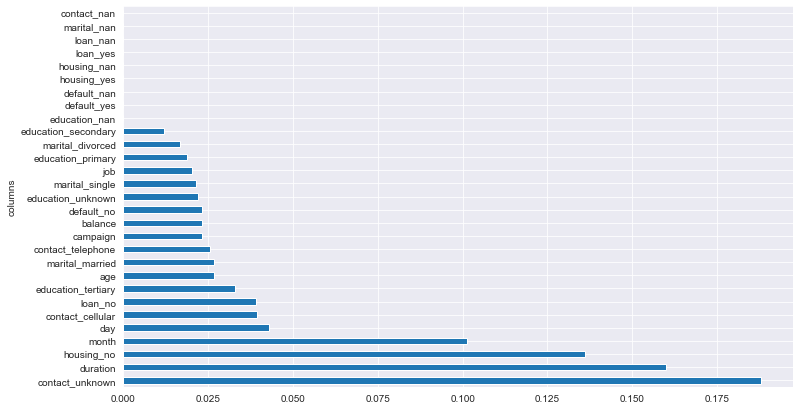

In [85]:
plot_feature_importance(rf_feat_importance(xg4, df_upsampled3.drop("y",axis=1)))